# CONTROLLER EXAMPLES

This notebook summarizes modeling with Antimony and constructing a PID controller.

# Preliminaries

In [3]:
import matplotlib.pyplot as plt
import numpy as np
try:
    import tellurium as te
except:
    !pip install -q tellurium
    import tellurium as te

# Antimony and Tellurium Basics

Antimony is a language for modeling chemical systems that allows the modeller to describe how species are transformed into other species by reactions.

A reaction has:
* a left hand side that specifies reactants
* a right hand side that specifies products
* a rate law that is a mathematical expression of the rate (flux) of the reaction

For example:

    J1: A + B -> C + D; k*A*B
    
    k = 2

``J1`` is the name of a reaction that transforms species ``A`` and ``B`` into ``C`` and ``D`` at a rate that is k times the current concentration of ``A`` and ``B``.

# Sequential Pathway

$S_1 \xrightarrow{k_1 S_1} S_2 \xrightarrow{k_2 S_2} S_3 \xrightarrow{k_3 S_3} \emptyset,~~ k_1 = 1, k_2 =2, k_3=0.5$

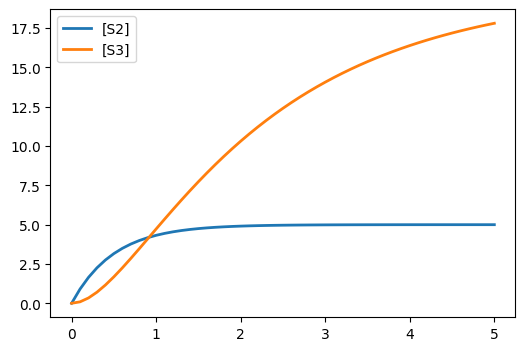

In [8]:
model = """
S1 -> S2; k1*S1
S2 -> S3; k2*S2
S3 -> ; k3*S3
k1 = 1
k2 = 2
k3 = 0.5
$S1 = 10  // $ makes this a boundary species
"""
rr = te.loada(model)
rr.simulate()
rr.plot()

1. Antimony model
2. Tellurium with plots
3. Regulating the output

# Creating a PID controller for a sequential pathway